# **Head Pose Estimation Project**

### **Project Goal:**
>**Predictng the three angles (Roll, Yaw, Pitch)** using supervised machine learning algorithms.

**Steps of the project**
> 1- Reading AFLW2000 dataset.

> 2- Apply mediapipe on each image, rescale the points to the image pixels and take (x,y) of each landmark.

> 3- Retrive the labels (pitch, yaw, roll) of each image from the .mat files in the dataset.

> 4- Create a dataframe that has features (468 landmarks points), number of features is 936 (468 for x and 468 for y),
>    the 3 labels (roll, yaw, pitch), and the image names.
>    `Size of the dataframe` = number of images * (number of features + 3 labels + image name).

> 5- Normalize landmarks values to avoid being affected by the size of the image or by the position of the face.

> 6- Splitting the data into train, validation and test.

> 7- Training different models on the data and compare their results.

> 8- Hyperparameter Tuning on the model with the best results, has the least MSE.

> 9- Testing the model on a new image.

> 10- Appplying the model on a video.

> 11- Saving the best models.

# **Importing Libraries**

In [121]:
# To extract the face important points(landmarks).
!pip install mediapipe
import mediapipe as mp

# To read the files from the directory.
import os
from os import listdir

# To deal with the lists as numpy arrays.
import numpy as np

# To deal with the images.
import cv2

# To display the images.
from google.colab.patches import cv2_imshow

# To read .mat files from the dataset.
import scipy.io as sio

# To calculate the 3 angles (Roll, Yaw, Pitch).
from math import cos, sin

# To deal with dataframes.
import pandas as pd

# To remove unnecessary warnings.
import warnings
warnings.filterwarnings('ignore')

# To split the data into train, validation, test.
from sklearn.model_selection import train_test_split

# Models used to predict the 3 labels.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# The metrics that will be used, to see how well is the model.
from sklearn.metrics import mean_squared_error, mean_absolute_error

# To help in tuning the parameters of the models.
from sklearn.model_selection import GridSearchCV

# To save the final model.
import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Reading the Dataset**

In [ ]:
# Uzipping the dataset
!unzip /content/drive/MyDrive/AFLW2000-3D

Archive:  /content/drive/MyDrive/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  in

# **What we want to predict to determine the head pose ?**
> We want to predict the 3 angles (`Roll`,`Yaw`, `Pitch`) to extimate the head pose.

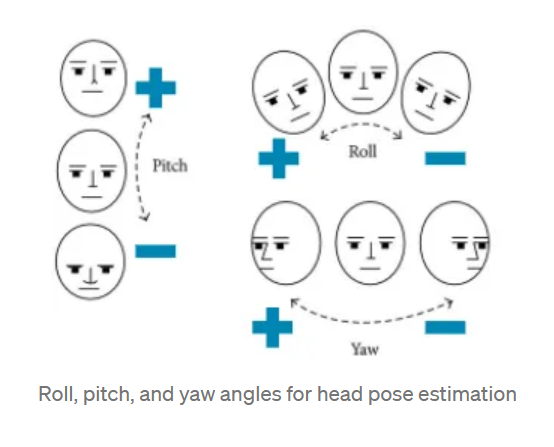

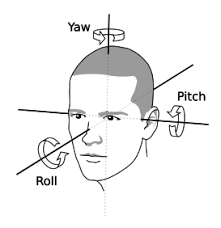

# **Converting the Dataset to a Dataframe**

**1- Detect the face_mesh**
> It extracts the 468 landmarks(x,y) of the face from the image.

> It returns a list of length 936 (468 columns for X + 468 columns for the Y).

In [ ]:
# import the modules
def extract_face_mesh(image, mpDraw, faceMesh , drawSpec, draw = False):
    
    # The list that will hold all the landmarks of the face (468 points).
    face = []

    # FaceMesh model accepts only RGB image, so we will convert it from BGR to RGB.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      
    
    # To get face_mesh points x,y of our image
    results = faceMesh.process(imgRGB)   
    
    # If a face is detected:
    if results.multi_face_landmarks:
        
        # Looping over the faces in the image (if we want to detect more than 1 face):
        for idx, faceLms in enumerate(results.multi_face_landmarks):
                
                # Looping over the landmarks of the image (468 landmark):
                for idx,lm in enumerate(faceLms.landmark):
                    
                  # To draw landmarks on the image default value = False
                    if draw:
                       mpDraw.draw_landmarks(image, faceLms, mpFaceMesh.FACEMESH_CONTOURS,drawSpec,drawSpec)
                    
                    # Landmarks are scaled, so invert the scaling to get the real values of the pixels:
                    ih, iw, ic = image.shape
                    x,y = int(lm.x*iw), int(lm.y*ih)

                    # Appending the values of the pixels in the same list
                    face.append(x)
                    face.append(y)
                
    return face

**2- Retrive the labels from .mat files**

In [ ]:
def get_labels_from_mat_file(mat_file_path):
        
        # Reading mat file using scipy library.
        mat_file = sio.loadmat(mat_file_path)  
        
        # Retriving the 3 labels (3 angles) of the image from the mat file:
        pitch, yaw, roll = mat_file["Pose_Para"][0][:3]
        
        return pitch, yaw, roll

**3- Create the dataframe**
> Loop on all the images in the dataset and extract their face landmarks.

> If the landmarks are extracted successfully, read the .mat file to get the labels of the image.

> Create a dataframe from the 468 face landmarks, the 3 labels and the image name.

In [ ]:
def create_df(dir_name):

   # To help us draw on our video(image), draw the points.
    mpDraw = mp.solutions.drawing_utils      
    
    # To create object that will help us to create the face_mesh.
    mpFaceMesh = mp.solutions.face_mesh                          

    # The function that will extract face_mesh from the image (468 landmarks). 
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)              

    # To change the design of the drawn mesh(change size of circles and thickness of the lines of the connection)
    drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=2)  
    
    # List of the landmarks' of all the images.
    faces_features = []
    
    # List of the Labels of all the images.
    pitch_target = []
    roll_target = []
    yaw_target = []
    
    # List of names of the images.
    images_names = []
    
    # Looping over each file in the dataset.
    for files in os.listdir(dir_name):
        
        # To make sure that the file is an image, since files of the dataset can be in 2 formats (image, or mat file).
        if (files.endswith(".jpg")):
            
            # This flag to make sure that the mat file will not be read, except if the face_mesh was successfully extracted.
            can_get_face_mesh = False
            
            # Read each image and extract its landmarks (468 point).
            image = cv2.imread(dir_name + "/" + files)
            face = extract_face_mesh(image, mpDraw, faceMesh , drawSpec)
            
            # To make sure that face_mesh landmarks was extracted successfully, its length will be 936 (468 for x + 468 for y).
            # If it failed to detect face landmarks, the list will be empty and its length will be 0. 
            if len(face) != 0:
                
                # Since landmarks are extracted successfully, change the flag to retrive 3 labels of this image.
                can_get_face_mesh = True
                
                #  Append values of the image's landmarks to the big list
                faces_features.append(face)
                
                # Append the name of the image to the list, to  know the image of these features.
                images_names.append(dir_name + "/" + files)
                         
            # If landmarks are extracted successfully and there is a mat file to read:
            if can_get_face_mesh:
                
                # Read the mat file using scipy library.
                mat_file = os.path.splitext(dir_name + "/" + files)[0]+'.mat'
                
                # To retrive the 3 labels of the image.
                pitch, yaw, roll = get_labels_from_mat_file(mat_file)
                
                # Append the 3 labels, each to its list.
                pitch_target.append(pitch)
                roll_target.append(roll)
                yaw_target.append(yaw)
     
    # To create names of columns which will be from X1, Y1 to X468, Y468 (number of landmarks).
    colns = []
    for i in range(1, 469):
        colns.append('X' + str(i))
        colns.append('Y' + str(i))
    
    # Create dataframe from landmarks of each image, and rename the columns as X and Y.
    df = pd.DataFrame(data = faces_features, columns = colns)
    
    
    # Append the 3 labels and the name of the image to the dataframe
    df['Yaw'] = yaw_target
    df['Pitch'] = pitch_target
    df['Roll'] = roll_target
    df["Image"] = images_names
    
    return df 

In [ ]:
# Converting the dataset to dataframe.
folder_dir = "/content/AFLW2000"
df = create_df(folder_dir)

In [ ]:
df

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X466,Y466,X467,Y467,X468,Y468,Yaw,Pitch,Roll,Image
0,238,308,251,283,239,291,237,256,252,275,...,238,233,264,218,266,214,-0.546056,-0.056755,-0.039170,/content/AFLW2000/image03677.jpg
1,229,300,229,280,229,285,221,251,229,272,...,241,227,287,213,291,210,0.101677,-0.281652,-0.092408,/content/AFLW2000/image01191.jpg
2,215,310,221,282,219,289,218,247,222,273,...,245,224,301,216,306,212,-0.001044,-0.167544,0.134020,/content/AFLW2000/image02989.jpg
3,230,309,217,287,224,291,206,259,215,280,...,227,230,274,209,278,205,0.179634,-0.284801,-0.279035,/content/AFLW2000/image01117.jpg
4,248,296,256,277,248,282,244,256,256,271,...,246,233,269,214,271,210,-0.847588,-0.416449,-0.069291,/content/AFLW2000/image03728.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,207,299,199,281,206,284,197,252,199,274,...,222,229,267,221,272,218,0.996781,-0.317447,-0.288747,/content/AFLW2000/image03128.jpg
1796,211,288,186,273,204,276,180,247,181,267,...,207,217,255,196,259,191,0.334907,-0.477806,-0.573797,/content/AFLW2000/image00311.jpg
1797,226,299,214,278,220,284,202,249,211,269,...,227,221,283,198,288,194,0.160344,-0.142706,-0.241610,/content/AFLW2000/image04242.jpg
1798,251,280,246,251,245,264,222,229,242,242,...,229,212,268,191,272,186,-0.284918,0.214353,-0.443023,/content/AFLW2000/image04289.jpg


# **Normalize the Image**

Normalize the image to make sure that the size of the image and the position of the face in the image does not matter.

**After Examining the image landmarks we found that:**
> The 5th point is at the center of the image (it is a point on the nose).

> Point number 199 is on the chin.

> Point number 9 is on the forehead.

> We used the 5th point to centralize the data around it.

> We got the distance between point number 9 and 199 to divide the data on this distance, and minimize the range of the data.

In [ ]:
def normalize_around_nose(df):
    # Create a copy from the original dataframe.
    centralized_df = df.copy()
    
    # A list that will carry all the images after normalization.
    normalized_list = []

    # centralize image around point number 5 (X5,Y5)
    for i in range(1, 469):
        for j in ['X', 'Y']:
            centralized_df[j + str(i)] = df[j + str(i)] - df[j+str(5)]
            
    # Calculate distance between forehead(X9, Y9) and chin (X199, Y199) using the Euclidean distance.
    distances = np.sqrt((df['X9'] - df['X199'])**2 + (df['Y9'] - df['Y199'])**2) 
    
    # Divide the centeralized data around 5th point on big distance (between forehead and chin), to rescale data.
    for i in range(len(df)):
         
        # It will contain the normalized pixels of 1 image.
        normalized_img = []

        # 936 is the number of columns 468 for X and 468 for Y.
        for col in df.columns[:936]:

            # Rescale data points and append it to the list.
            normalized_img.append(centralized_df[col][i]/distances[i])

        # Append the normalized image to the list.
        normalized_list.append(normalized_img) 

    # Convert the list of all images to a dataframe and return it.
    normalized_df = pd.DataFrame(data = normalized_list, columns = df.columns[:936])
    return normalized_df

In [ ]:
# Normalize the dataframe.
normalized_df = normalize_around_nose(df)

In [ ]:
normalized_df

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X464,Y464,X465,Y465,X466,Y466,X467,Y467,X468,Y468
0,-0.257630,0.607271,-0.018402,0.147217,-0.239228,0.294434,-0.276032,-0.349641,0.0,0.0,...,-0.257630,-0.864900,-0.276032,-0.809694,-0.257630,-0.772890,0.220826,-1.048922,0.257630,-1.122530
1,0.000000,0.517720,0.000000,0.147920,0.000000,0.240370,-0.147920,-0.388290,0.0,0.0,...,0.332820,-0.924500,0.258860,-0.887520,0.221880,-0.832050,1.072420,-1.090910,1.146380,-1.146380
2,-0.104350,0.551563,-0.014907,0.134164,-0.044721,0.238514,-0.059628,-0.387585,0.0,0.0,...,0.477028,-0.790077,0.402492,-0.760263,0.342864,-0.730449,1.177662,-0.849706,1.252198,-0.909334
3,0.276595,0.534750,0.036879,0.129077,0.165957,0.202836,-0.165957,-0.387232,0.0,0.0,...,0.331914,-1.032620,0.258155,-0.977301,0.221276,-0.921982,1.087939,-1.309215,1.161697,-1.382973
4,-0.178885,0.559017,0.000000,0.134164,-0.178885,0.245967,-0.268328,-0.335410,0.0,0.0,...,-0.201246,-1.006231,-0.245967,-0.916788,-0.223607,-0.849706,0.290689,-1.274559,0.335410,-1.364001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.160064,0.500200,0.000000,0.140056,0.140056,0.200080,-0.040016,-0.440176,0.0,0.0,...,0.600240,-1.020408,0.520208,-0.960384,0.460184,-0.900360,1.360544,-1.060424,1.460584,-1.120448
1796,0.565635,0.395945,0.094273,0.113127,0.433654,0.169691,-0.018855,-0.377090,0.0,0.0,...,0.641053,-1.112416,0.565635,-1.018143,0.490217,-0.942725,1.395233,-1.338670,1.470651,-1.432942
1797,0.266459,0.532918,0.053292,0.159875,0.159875,0.266459,-0.159875,-0.355278,0.0,0.0,...,0.444098,-0.959252,0.355278,-0.905960,0.284223,-0.852668,1.279002,-1.261239,1.367822,-1.332294
1798,0.166552,0.703222,0.074023,0.166552,0.055517,0.407128,-0.370117,-0.240576,0.0,0.0,...,-0.185058,-0.610692,-0.240576,-0.573681,-0.240576,-0.555175,0.481152,-0.943797,0.555175,-1.036326


# **Seperate Features from Labels**

In [ ]:
# features are the 468 landmarks points.
features = normalized_df
features

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X464,Y464,X465,Y465,X466,Y466,X467,Y467,X468,Y468
0,-0.257630,0.607271,-0.018402,0.147217,-0.239228,0.294434,-0.276032,-0.349641,0.0,0.0,...,-0.257630,-0.864900,-0.276032,-0.809694,-0.257630,-0.772890,0.220826,-1.048922,0.257630,-1.122530
1,0.000000,0.517720,0.000000,0.147920,0.000000,0.240370,-0.147920,-0.388290,0.0,0.0,...,0.332820,-0.924500,0.258860,-0.887520,0.221880,-0.832050,1.072420,-1.090910,1.146380,-1.146380
2,-0.104350,0.551563,-0.014907,0.134164,-0.044721,0.238514,-0.059628,-0.387585,0.0,0.0,...,0.477028,-0.790077,0.402492,-0.760263,0.342864,-0.730449,1.177662,-0.849706,1.252198,-0.909334
3,0.276595,0.534750,0.036879,0.129077,0.165957,0.202836,-0.165957,-0.387232,0.0,0.0,...,0.331914,-1.032620,0.258155,-0.977301,0.221276,-0.921982,1.087939,-1.309215,1.161697,-1.382973
4,-0.178885,0.559017,0.000000,0.134164,-0.178885,0.245967,-0.268328,-0.335410,0.0,0.0,...,-0.201246,-1.006231,-0.245967,-0.916788,-0.223607,-0.849706,0.290689,-1.274559,0.335410,-1.364001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.160064,0.500200,0.000000,0.140056,0.140056,0.200080,-0.040016,-0.440176,0.0,0.0,...,0.600240,-1.020408,0.520208,-0.960384,0.460184,-0.900360,1.360544,-1.060424,1.460584,-1.120448
1796,0.565635,0.395945,0.094273,0.113127,0.433654,0.169691,-0.018855,-0.377090,0.0,0.0,...,0.641053,-1.112416,0.565635,-1.018143,0.490217,-0.942725,1.395233,-1.338670,1.470651,-1.432942
1797,0.266459,0.532918,0.053292,0.159875,0.159875,0.266459,-0.159875,-0.355278,0.0,0.0,...,0.444098,-0.959252,0.355278,-0.905960,0.284223,-0.852668,1.279002,-1.261239,1.367822,-1.332294
1798,0.166552,0.703222,0.074023,0.166552,0.055517,0.407128,-0.370117,-0.240576,0.0,0.0,...,-0.185058,-0.610692,-0.240576,-0.573681,-0.240576,-0.555175,0.481152,-0.943797,0.555175,-1.036326


In [ ]:
labels = df.loc[:, df.columns.isin(['Yaw', 'Pitch', 'Roll'])]
labels

,Yaw,Pitch,Roll
0,-0.546056,-0.056755,-0.039170
1,0.101677,-0.281652,-0.092408
2,-0.001044,-0.167544,0.134020
3,0.179634,-0.284801,-0.279035
4,-0.847588,-0.416449,-0.069291
...,...,...,...
1795,0.996781,-0.317447,-0.288747
1796,0.334907,-0.477806,-0.573797
1797,0.160344,-0.142706,-0.241610
1798,-0.284918,0.214353,-0.443023


# **Splitting the Data**

> Splitting the data into train with 60%, validation with 20%, and test with 20%.

In [ ]:
# Used random state = 100 to make sure we always get the same results.
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features, labels, test_size=0.4, random_state=100)

In [ ]:
features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.5, random_state=100)

# **Models**

> Now we are ready to use different models to predict the labels.

> We have 3 labels (`Roll, Yaw, Pitch`), that we want to predict, so we will create 3 different models for the 3 angles.

# **1- Linear Regression**

**1- Predicting Roll Angle**

In [ ]:
# Create LinearRegression model and fit it on the train data.
roll_reg = LinearRegression()
roll_reg.fit(features_train, labels_train["Roll"])
 
# Use the trained model to predict the labels of the train data, validation data, and test data.
reg_roll_train_predicted = roll_reg.predict(features_train)
reg_roll_val_predicted = roll_reg.predict(features_validation)
reg_roll_test_predicted = roll_reg.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Roll"], reg_roll_train_predicted))
print(mean_absolute_error(labels_train["Roll"], reg_roll_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Roll"], reg_roll_val_predicted))
print(mean_absolute_error(labels_validation["Roll"], reg_roll_val_predicted))

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Roll"], reg_roll_test_predicted))
print(mean_absolute_error(labels_test["Roll"], reg_roll_test_predicted))

Training scores: 
0.0211001383187983
0.11150203761952908

Validation scores: 
1.5460827597764983
0.9661718568072755

Test scores: 
1.4649031503133716
0.9600738415179424


**2- Predicting Yaw Angle**

In [ ]:
# Create LinearRegression model and fit it on the train data.
yaw_reg = LinearRegression()
yaw_reg.fit(features_train, labels_train["Yaw"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
reg_yaw_train_predicted = yaw_reg.predict(features_train)
reg_yaw_val_predicted = yaw_reg.predict(features_validation)
reg_yaw_test_predicted = yaw_reg.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Yaw"], reg_yaw_train_predicted))
print(mean_absolute_error(labels_train["Yaw"], reg_yaw_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Yaw"], reg_yaw_val_predicted))
print(mean_absolute_error(labels_validation["Yaw"], reg_yaw_val_predicted))

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Yaw"], reg_yaw_test_predicted))
print(mean_absolute_error(labels_test["Yaw"], reg_yaw_test_predicted))

Training scores: 
0.005373978272501729
0.05772154672313644

Validation scores: 
0.29137346242535644
0.4291677308513071

Test scores: 
0.2670347401457699
0.4113673945087269


**3- Predicting Pitch Angle**

In [ ]:
# Create LinearRegression model and fit it on the train data.
pitch_reg = LinearRegression()
pitch_reg.fit(features_train, labels_train["Pitch"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
reg_pitch_train_predicted = pitch_reg.predict(features_train)
reg_pitch_val_predicted = pitch_reg.predict(features_validation)
reg_pitch_test_predicted = pitch_reg.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Pitch"], reg_pitch_train_predicted))
print(mean_absolute_error(labels_train["Pitch"], reg_pitch_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Pitch"], reg_pitch_val_predicted))
print(mean_absolute_error(labels_validation["Pitch"], reg_pitch_val_predicted))

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Pitch"], reg_pitch_test_predicted))
print(mean_absolute_error(labels_test["Pitch"], reg_pitch_test_predicted))

Training scores: 
0.0212955905788408
0.11455126951441327

Validation scores: 
1.1154434995022513
0.8133834733829792

Test scores: 
1.1063265602773558
0.8324800697098154


From the big difference between the training scores and the validation, test scores, we find that linear regression is overfitting. 

# **2- SVR**

**1- Predicting Roll Angle**

In [136]:
# Create SVR model and fit it on the train data.
roll_svr = SVR()
roll_svr.fit(features_train, labels_train["Roll"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_roll_train_predicted = roll_svr.predict(features_train)
svr_roll_val_predicted = roll_svr.predict(features_validation)
svr_roll_test_predicted = roll_svr.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Roll"], svr_roll_train_predicted))
print(mean_absolute_error(labels_train["Roll"],svr_roll_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Roll"], svr_roll_val_predicted)),
print(mean_absolute_error(labels_validation["Roll"], svr_roll_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Roll"], svr_roll_test_predicted))
print(mean_absolute_error(labels_test["Roll"], svr_roll_test_predicted))

Training scores: 
0.26521308625536094
0.09572638345754014

Validation scores: 
0.06132743445897649
0.09691992009077235

Test scores: 
0.03736289936526401
0.09306274725883538


**2- Predicting Yaw Angle**

In [137]:
# Create SVR model and fit it on the train data.
yaw_svr = SVR()
yaw_svr.fit(features_train, labels_train["Yaw"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_yaw_train_predicted = yaw_svr.predict(features_train)
svr_yaw_val_predicted = yaw_svr.predict(features_validation)
svr_yaw_test_predicted = yaw_svr.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Yaw"], svr_yaw_train_predicted))
print(mean_absolute_error(labels_train["Yaw"],svr_yaw_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Yaw"], svr_yaw_val_predicted)),
print(mean_absolute_error(labels_validation["Yaw"], svr_yaw_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Yaw"], svr_yaw_test_predicted))
print(mean_absolute_error(labels_test["Yaw"], svr_yaw_test_predicted))

Training scores: 
0.059336754159129396
0.14110433146275092

Validation scores: 
0.05576054390185877
0.14460166016806858

Test scores: 
0.03875941680698568
0.13254265941359017


**3- Predicting Pitch Angle**

In [138]:
# Create SVR model and fit it on the train data.
pitch_svr = SVR()
pitch_svr.fit(features_train, labels_train["Pitch"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_pitch_train_predicted = pitch_svr.predict(features_train)
svr_pitch_val_predicted = pitch_svr.predict(features_validation)
svr_pitch_test_predicted = pitch_svr.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Pitch"], svr_pitch_train_predicted))
print(mean_absolute_error(labels_train["Pitch"],svr_pitch_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Pitch"], svr_pitch_val_predicted)),
print(mean_absolute_error(labels_validation["Pitch"], svr_pitch_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Pitch"], svr_pitch_test_predicted))
print(mean_absolute_error(labels_test["Pitch"], svr_pitch_test_predicted))

Training scores: 
0.24696592963572708
0.11767224848333918

Validation scores: 
0.06396486442622222
0.11816887955661581

Test scores: 
0.031674307540891816
0.10487715698797268


# **3- RandomForestRegressor**

**1- Predicting Roll Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
roll_rf = RandomForestRegressor()
roll_rf.fit(features_train, labels_train["Roll"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
rf_roll_train_predicted = roll_rf.predict(features_train)
rf_roll_val_predicted = roll_rf.predict(features_validation)
rf_roll_test_predicted = roll_rf.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Roll"], rf_roll_train_predicted))
print(mean_absolute_error(labels_train["Roll"],rf_roll_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Roll"], rf_roll_val_predicted)),
print(mean_absolute_error(labels_validation["Roll"], rf_roll_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Roll"], rf_roll_test_predicted))
print(mean_absolute_error(labels_test["Roll"], rf_roll_test_predicted)) 

Training scores: 
0.05089762981682311
0.05378197917896441

Validation scores: 
0.16539952315606665
0.12239035226626784

Test scores: 
0.1664012745065568
0.12622849291945498


**2- Predicting Yaw Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
yaw_rf = RandomForestRegressor()
yaw_rf.fit(features_train, labels_train["Yaw"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
rf_yaw_train_predicted = yaw_rf.predict(features_train)
rf_yaw_val_predicted = yaw_rf.predict(features_validation)
rf_yaw_test_predicted = yaw_rf.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Yaw"], rf_yaw_train_predicted))
print(mean_absolute_error(labels_train["Yaw"],rf_yaw_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Yaw"], rf_yaw_val_predicted)),
print(mean_absolute_error(labels_validation["Yaw"], rf_yaw_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Yaw"], rf_yaw_test_predicted))
print(mean_absolute_error(labels_test["Yaw"], rf_yaw_test_predicted))

Training scores: 
0.008768570433295094
0.05614986745294835

Validation scores: 
0.060200744486073286
0.15657444870002327

Test scores: 
0.04214408139961529
0.1404077829656146


**3- Predicting Pitch Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
pitch_rf = RandomForestRegressor()
pitch_rf.fit(features_train, labels_train["Pitch"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
rf_pitch_train_predicted = pitch_rf.predict(features_train)
rf_pitch_val_predicted = pitch_rf.predict(features_validation)
rf_pitch_test_predicted = pitch_rf.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Pitch"], rf_pitch_train_predicted))
print(mean_absolute_error(labels_train["Pitch"],rf_pitch_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Pitch"], rf_pitch_val_predicted)),
print(mean_absolute_error(labels_validation["Pitch"], rf_pitch_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Pitch"], rf_pitch_test_predicted))
print(mean_absolute_error(labels_test["Pitch"], rf_pitch_test_predicted))

Training scores: 
0.04071443154586334
0.05628680325403554

Validation scores: 
0.12609173128295825
0.14826981340436282

Test scores: 
0.07125628258189824
0.1344897754828162


# **4- GradientBoostingRegressor**

**1- Predicting Roll Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
roll_gb = GradientBoostingRegressor()
roll_gb.fit(features_train, labels_train["Roll"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
gb_roll_train_predicted = roll_gb.predict(features_train)
gb_roll_val_predicted = roll_gb.predict(features_validation)
gb_roll_test_predicted = roll_gb.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Roll"], gb_roll_train_predicted))
print(mean_absolute_error(labels_train["Roll"],gb_roll_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Roll"], gb_roll_val_predicted)),
print(mean_absolute_error(labels_validation["Roll"], gb_roll_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Roll"], gb_roll_test_predicted))
print(mean_absolute_error(labels_test["Roll"], gb_roll_test_predicted))

Training scores: 
0.006189027850727944
0.05186022191127971

Validation scores: 
0.10134401031051203
0.11494510761261287

Test scores: 
0.17538273208542363
0.13077779555240668


**2- Predicting Yaw Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
yaw_gb = GradientBoostingRegressor()
yaw_gb.fit(features_train, labels_train["Yaw"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
gb_yaw_train_predicted = yaw_gb.predict(features_train)
gb_yaw_val_predicted = yaw_gb.predict(features_validation)
gb_yaw_test_predicted = yaw_gb.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Yaw"], gb_yaw_train_predicted))
print(mean_absolute_error(labels_train["Yaw"],gb_yaw_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Yaw"], gb_yaw_val_predicted)),
print(mean_absolute_error(labels_validation["Yaw"], gb_yaw_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Yaw"], gb_yaw_test_predicted))
print(mean_absolute_error(labels_test["Yaw"], gb_yaw_test_predicted))

Training scores: 
0.012186346462220984
0.0799132185101352

Validation scores: 
0.05708815595510625
0.1512916690538761

Test scores: 
0.03979378817216437
0.13981485673809949


**3- Predicting Pitch Angle**

In [ ]:
# Create RandomForestRegressor model and fit it on the train data.
pitch_gb = GradientBoostingRegressor()
pitch_gb.fit(features_train, labels_train["Pitch"])

# Use the trained model to predict the labels of the train data, validation data, and test data.
gb_pitch_train_predicted = pitch_gb.predict(features_train)
gb_pitch_val_predicted = pitch_gb.predict(features_validation)
gb_pitch_test_predicted = pitch_gb.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Pitch"], gb_pitch_train_predicted))
print(mean_absolute_error(labels_train["Pitch"],gb_pitch_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Pitch"], gb_pitch_val_predicted)),
print(mean_absolute_error(labels_validation["Pitch"], gb_pitch_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Pitch"], gb_pitch_test_predicted))
print(mean_absolute_error(labels_test["Pitch"], gb_pitch_test_predicted))

Training scores: 
0.008644193805599679
0.06709982492547985

Validation scores: 
0.11332948111867541
0.14897785338740296

Test scores: 
0.09157673373520187
0.1400052329480922


# **Tuning the hyperparameters of the best model**

**From the results we find that SVR has the best result, so we will tune its parameters to get better results if possible.**
> Use `GridSearch` to find the best parameters for each model (Roll_Model, Yaw_Model, Pitch_Model).

In [ ]:
def grid_search(model, parameters, features_train, labels_train):
    model_gs = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'neg_mean_squared_error')
    model_gs.fit(features_train, labels_train)
    
    model_winner = model_gs.best_estimator_
    print(f"Best model is {model_winner}")
    return model_winner

**Tuning Roll SVR Model**

In [ ]:
svr_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.01, 0.1, 1 , 10, 100],
                  'gamma': [0.01, 0.1, 1, 10, 100],
                }
roll_svr = SVR()
roll_svr_winner = grid_search(roll_svr, svr_parameters, features_train, labels_train["Roll"])

Best model is  SVR(C=0.1, gamma=0.01, kernel='linear')


In [130]:
# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_winner_roll_train_predicted = roll_svr_winner.predict(features_train)
svr_winner_roll_val_predicted = roll_svr_winner.predict(features_validation)
svr_winner_roll_test_predicted = roll_svr_winner.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Roll"], svr_winner_roll_train_predicted))
print(mean_absolute_error(labels_train["Roll"],svr_winner_roll_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Roll"], svr_winner_roll_val_predicted)),
print(mean_absolute_error(labels_validation["Roll"], svr_winner_roll_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Roll"], svr_winner_roll_test_predicted))
print(mean_absolute_error(labels_test["Roll"], svr_winner_roll_test_predicted))

Training scores: 
0.2639191011573765
0.09442476833016086

Validation scores: 
0.06306743728010275
0.10130363880891965

Test scores: 
0.036561266616568264
0.09521589779411552


**Tuning Yaw SVR Model**

In [133]:
yaw_svr = SVR()
yaw_svr_winner = grid_search(yaw_svr, svr_parameters, features_train, labels_train["Yaw"])

Best model is SVR(C=1, gamma=0.01, kernel='poly')


In [ ]:
# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_winner_yaw_train_predicted = yaw_svr_winner.predict(features_train)
svr_winner_yaw_val_predicted = yaw_svr_winner.predict(features_validation)
svr_winner_yaw_test_predicted = yaw_svr_winner.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Yaw"], svr_winner_yaw_train_predicted))
print(mean_absolute_error(labels_train["Yaw"],svr_winner_yaw_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Yaw"], svr_yaw_val_predicted)),
print(mean_absolute_error(labels_validation["Yaw"], svr_winner_yaw_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Yaw"], svr_winner_yaw_test_predicted))
print(mean_absolute_error(labels_test["Yaw"], svr_winner_yaw_test_predicted))

Training scores: 
0.021219067396415405
0.08808960934833716

Validation scores: 
0.05576054390185877
0.1241172801327867

Test scores: 
0.025064541615932502
0.11388680040752736


**Tuning Pitch SVR Model**

In [ ]:
pitch_svr = SVR()
pitch_svr_winner = grid_search(pitch_svr, svr_parameters, features_train, labels_train["Pitch"])

Best model is SVR(C=1, gamma=0.01, kernel='linear')


In [ ]:
# Use the trained model to predict the labels of the train data, validation data, and test data.
svr_winner_pitch_train_predicted = pitch_svr_winner.predict(features_train)
svr_winner_pitch_val_predicted = pitch_svr_winner.predict(features_validation)
svr_winner_pitch_test_predicted = pitch_svr_winner.predict(features_test)

# Print the Mean square error and the absolute error on the training.
print("Training scores: ")
print(mean_squared_error(labels_train["Pitch"], svr_winner_pitch_train_predicted))
print(mean_absolute_error(labels_train["Pitch"],svr_winner_pitch_train_predicted))

# Print the Mean square error and the absolute error on the validation.
print("\nValidation scores: ")
print(mean_squared_error(labels_validation["Pitch"], svr_winner_pitch_val_predicted)),
print(mean_absolute_error(labels_validation["Pitch"], svr_winner_pitch_val_predicted)),

# Print the Mean square error and the absolute error on the test.
print("\nTest scores: ")
print(mean_squared_error(labels_test["Pitch"], svr_winner_pitch_test_predicted))
print(mean_absolute_error(labels_test["Pitch"], svr_winner_pitch_test_predicted))

Training scores: 
0.24090024662990847
0.11072954394313021

Validation scores: 
0.06985204560541099
0.12625466080121497

Test scores: 
0.03446300573744265
0.11388035858523118


**Hyperparameters of the SVR models after gridsearch are:**
> `Roll Model` : SVR(C=0.1, gamma=0.01, kernel='linear').

> `Yaw Model` : SVR(C=1, gamma=0.01, kernel='poly').

> `Pitch Model` : SVR(C=1, gamma=0.01, kernel='linear').

**The Default hyperparameters of the 3 SVR models are:**
>     SVR(C=1.0, gamma='scale', kernel='rbf').



After using the 2 sets of hyperparameters and seeing the results, we found that the default hyperparameters gave better result, so we will stick to them.

# **Testing the Model**

 **Using the trained SVR models to predict angles on both images and videos**

#### A function to draw the axis using the predicted angles.

**Its parameters are:**

>img: the image we want to draw axis on.

>pitch: pitch angle we predicted.

>yaw: yaw angle we predicted.

>roll: roll angle we predicted.

>tdx: transition on x axis, if not given it's half the width of the image.

>tdy: transition on y axis, if not given it's half the height of the image.

>size: size of the drawn axis.


In [147]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### **Testing on an Image**

In [143]:
def predict_img(img_path):
    # To help us draw on our video(image), draw the points.
    mpDraw = mp.solutions.drawing_utils      
    
    # To create object to create the face_mesh.
    mpFaceMesh = mp.solutions.face_mesh                          

    # The function that will extract face_mesh from the image 468 landmarks. 
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)              

    # To change the design of the drawn mesh(change size of circles and thickness of the lines of the connection).
    drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=2)  

    # To read the image and extract the face_mesh landmarks.
    image = cv2.imread(img_path)
    face_mesh_landmarks  = extract_face_mesh(image, mpDraw, faceMesh , drawSpec)

    # Checking weither extracting the landmarks was successful or not.
    if face_mesh_landmarks:

      # To create names of columns which will be from X1, Y1 to X468, Y468 (number of landmarks).
      colns = []
      for i in range(1, 469):
          colns.append('X' + str(i))
          colns.append('Y' + str(i))
    
      # Create dataframe from landmarks of each image, and rename the columns as X and Y.
      img_df = pd.DataFrame(face_mesh_landmarks).T
      img_df.columns = colns

      # Normalize the image to make sure that the size and the position of the face in the image does not matter.
      norm_df = normalize_around_nose(img_df)

      # Draw axis on the image with the predicted angles.
      cv2_imshow(draw_axis(image.copy(), pitch_svr.predict(norm_df)[0], yaw_svr.predict(norm_df)[0], roll_svr.predict(norm_df)[0], img_df['X5'][0], img_df['Y5'][0] ))


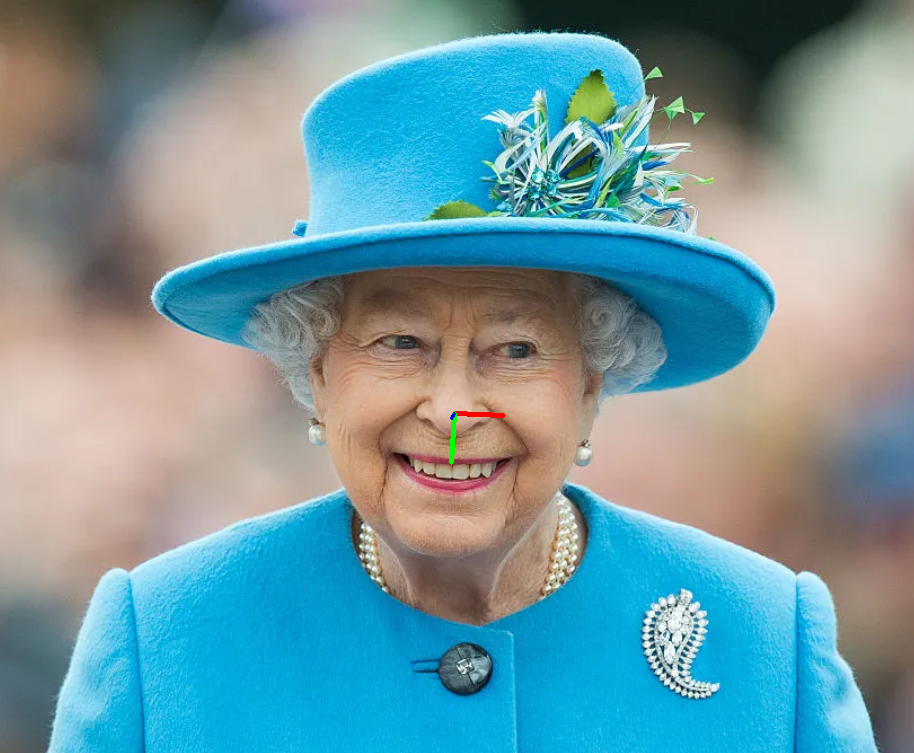

In [144]:
predict_img("/content/Capture1.jpg")

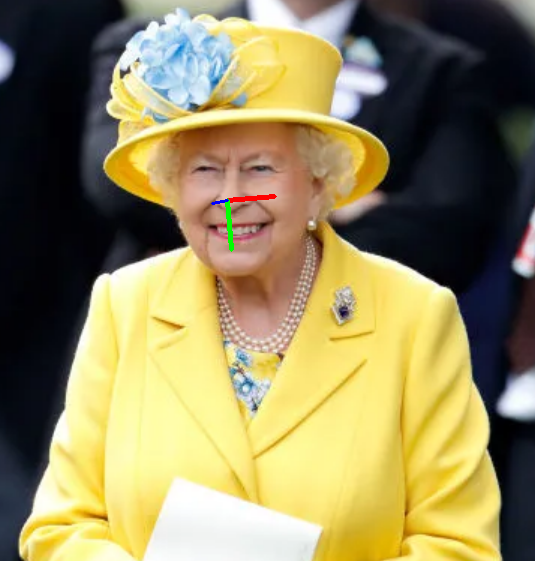

In [145]:
predict_img("/content/Capture4.PNG")

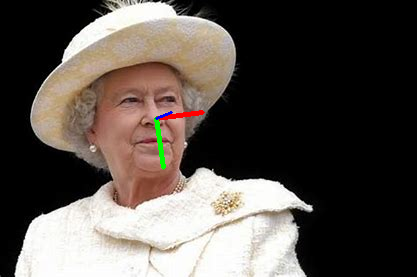

In [146]:
predict_img("/content/download (2).jpg")

### **Testing on a Video**

In [ ]:
def predict_video(video_path):

  # Returns a video capture object which we can use to display the video.
  cap = cv2.VideoCapture(video_path)

  # To help us draw on our video(image), draw the points.
  mpDraw = mp.solutions.drawing_utils      
    
  # To create object to create the face_mesh.
  mpFaceMesh = mp.solutions.face_mesh                          

  # The function that will extract face_mesh from the image 468 landmarks. 
  faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)              

  # To change the design of the drawn mesh(change size of circles and thickness of the lines of the connection).
  drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=2) 

  faces = []

  # To create names of columns which will be from X1, Y1 to X468, Y468 (number of landmarks).
  colns = []
  for i in range(1, 469):
     colns.append('X' + str(i))
     colns.append('Y' + str(i))

  # True if video capturing has been initialized already.
  if cap.isOpened():

    # To get the width and the height of the frame.
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Convert the width and the height to a tuple of integer.
    res=(int(width), int(height))

    # To determine the encoding method of video, we put fourcc = *'mp4v' as we are dealing with mp4 videos.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') #codec

    # To get video frame rate.
    framespersecond= int(cap.get(cv2.CAP_PROP_FPS))

    # To save the video.
    out = cv2.VideoWriter('Modified' + video_path , fourcc, framespersecond, res)

    frame = None
    while True:
        try:
            # Returns true if the frame is available, and returns the frame.
            is_success, frame = cap.read()

        except cv2.error:
            continue

        if not is_success:
            break
        
        # To extract face_mesh landmarks.
        face = extract_face_mesh(frame, mpDraw, faceMesh , drawSpec)

        # Checking weither extracting the landmarks was successful or not.
        if face:

          # Create dataframe from landmarks of each image, and rename the columns as X and Y.
          frame_df = pd.DataFrame(face).T
          frame_df.columns = colns

          # Normalize the image to make sure that the size and the position of the face in the image does not matter.
          scaled_frame_df = normalize_around_nose(frame_df)
            
          # To use the trained models to predict the 3 angles.
          pitch = pitch_svr.predict(scaled_frame_df)
          yaw = yaw_svr.predict(scaled_frame_df)
          roll = roll_svr.predict(scaled_frame_df)     
         
         # To draw the axis on the frame.
          count = 0     
          for index in (scaled_frame_df.index):    
             new_img = draw_axis(frame, pitch[count], yaw[count], roll[count], frame_df['X5'][index], frame_df['Y5'][index] )
             count += 1

          # Save the new frame.
          out.write(new_img)
    out.release() 

  # Close video file.
  cap.release()

In [ ]:
predict_video('/content/trimmed_video1.mp4')

# **Saving the Models**

> Saving the trained models to use it for forward prediction.

**1- Saving Roll Model**


In [148]:
# Save the roll model to disk.
joblib.dump(roll_svr, 'roll_model.sav')

['roll_model.sav']

**2- Saving Yaw Model**


In [149]:
# Save the yaw model to disk.
joblib.dump(yaw_svr, 'yaw_model.sav')

['yaw_model.sav']

**3- Saving pitch Model**

In [151]:
# Save the pitch model to disk.
joblib.dump(pitch_svr, 'pitch_model.sav')

['pitch_model.sav']